# Classifier Training - With overlapping chunks
This script is creating the complete dataset and training various classifiers. The dataset is prepared such that 4 seconds of overlapping chunks are picked out of each record, total number of chunks for a single record being 4. 

The processing is as follows:
1. PCG records are loaded and chunked.
2. Chunks are normalized usng RMS normalization
3. Extraction of feature 1: **PCA of MFCC**
4. Extraction of feature 2: **Statistics of MFCC**
5. Extraction of feature 3: **Bandpower ratio**
6. Loading segmentation features and mergin all features and labels into a single array
7. Calculating K-Fold validation for Logistic Regression, Random Forest and AdaBoost classifiers

**Note:** *K-Fold validation is done such that all chunk of a record belongs to either training or test set.*

In [1]:
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from python_speech_features import mfcc
from python_speech_features import delta
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import scipy
from utils import *
import random


**Data Loading and RMS Normalization**

In [2]:
sampling_frequency = 2000 # in Hz
slice_length = 4          # in seconds
overlap = 2               # in seconds

normal_records, normal_records_denoised = load_records(path = '../dataset/normal_tracings.txt',normalize = False, crop = 20000)
abnormal_records, abnormal_records_denoised = load_records(path = '../dataset/abnormal_tracings.txt',normalize = False, crop = 20000)
records_train = np.concatenate((abnormal_records_denoised, normal_records_denoised), axis=0)
labels = np.concatenate((np.ones((abnormal_records_denoised.shape[0],1)),np.zeros((normal_records.shape[0],1))), axis=0)

normal_records_chunks = np.zeros((normal_records_denoised.shape[0], 4, slice_length*sampling_frequency))
slices = np.arange(0, 10, slice_length-overlap, dtype=int)
for i in range(normal_records.shape[0]):
    j = 0
    for start, end in zip(slices[:-1], slices[1:]):
        start_audio = start * sampling_frequency
        end_audio = (end + overlap)* sampling_frequency
        chunk = normal_records_denoised[i, int(start_audio): int(end_audio)]
        normal_records_chunks[i, j, :] = chunk
        j = j + 1  
        
abnormal_records_chunks = np.zeros((abnormal_records_denoised.shape[0], 4, slice_length*sampling_frequency))
for i in range(abnormal_records.shape[0]):
    j = 0
    for start, end in zip(slices[:-1], slices[1:]):
        start_audio = start * sampling_frequency
        end_audio = (end + overlap)* sampling_frequency
        chunk = abnormal_records_denoised[i, int(start_audio): int(end_audio)]
        abnormal_records_chunks[i, j, :] = chunk
        j = j + 1  

abnormal_records_chunks_reshaped = np.reshape(abnormal_records_chunks, (33*4, 8000))
normal_records_chunks_reshaped = np.reshape(normal_records_chunks, (29*4, 8000))
all_records_chunked = np.concatenate((abnormal_records_chunks_reshaped, normal_records_chunks_reshaped), axis = 0)
all_records_chunked_normalized = np.zeros_like(all_records_chunked)
labels_chunked = np.concatenate((np.ones((abnormal_records_chunks_reshaped.shape[0],1)),np.zeros((normal_records_chunks_reshaped.shape[0],1))), axis=0)


for i in range(all_records_chunked.shape[0]):
    data = all_records_chunked[i,:]
    rms_level = 0
    r = 10**(rms_level / 10.0)
    a = np.sqrt( (len(data) * r**2) / np.sum(data**2) )
    data = data * a
    all_records_chunked_normalized[i,:] = data


**Feature 1: PCA of MFCC**

In [3]:
all_mfcc = []
all_mfcc_delta = []
all_mfcc_delta2 = []
for im in range(all_records_chunked_normalized.shape[0]): 
    mfc_coefs = mfcc(all_records_chunked_normalized[im,:],  samplerate=2000, winlen =0.1, winstep = 0.1, nfft = 1024)
    mfc_coefs = mfc_coefs.T
    delta_mfc_coefs = delta(mfc_coefs, 3)
    delta2_mfc_coefs = delta(delta_mfc_coefs, 2)
    
    all_mfcc.append(mfc_coefs)
    all_mfcc_delta.append(delta_mfc_coefs)
    all_mfcc_delta2.append(delta2_mfc_coefs)

all_mfcc = np.array(all_mfcc)
all_mfcc_delta = np.array(all_mfcc_delta)
all_mfcc_delta2 = np.array(all_mfcc_delta2)

mfcc_pca = []
for im in range(0,13):
    pca = PCA(n_components=1)
    mfcc_transformed = pca.fit_transform(np.array(all_mfcc)[:,im,:])
    mfcc_pca.append(mfcc_transformed[:,0])  
mfcc_pca = np.array(mfcc_pca).T  #248x13

delta_mfcc_pca = []
for im in range(0,13):
    pca = PCA(n_components=1)
    delta_mfcc_transformed = pca.fit_transform(np.array(all_mfcc_delta)[:,im,:])
    delta_mfcc_pca.append(delta_mfcc_transformed[:,0])
delta_mfcc_pca = np.array(delta_mfcc_pca).T  #248x13

delta2_mfcc_pca = []
for im in range(0,13):
    pca = PCA(n_components=1)
    delta2_mfcc_transformed = pca.fit_transform(np.array(all_mfcc_delta2)[:,im,:])
    delta2_mfcc_pca.append(delta2_mfcc_transformed[:,0])
delta2_mfcc_pca = np.array(delta2_mfcc_pca).T  #248x13

#plot_singleFeature(delta2_mfcc_pca[:,7], "9. Delta-MFCC feature with dimensionality reduced in time domain via PCA (winlen:0.1 sec)")

**Feature 2: Statistics of MFCC**

In [4]:
mfcc_means = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')  #248x13
mfcc_std = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')
mfcc_max = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')
mfcc_min = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')

mfcc_delta_means = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')
mfcc_delta_std = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')
mfcc_delta_max = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')
mfcc_delta_min = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')

mfcc_delta2_means = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')
mfcc_delta2_std = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')
mfcc_delta2_max = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')
mfcc_delta2_min = np.zeros((all_records_chunked_normalized.shape[0],13),dtype='float32')


for im in range(all_records_chunked_normalized.shape[0]):   
    for j in range(13):
        mfcc_means[im,j] = np.mean(all_mfcc[im,j,:])
        mfcc_std[im,j] = np.std(all_mfcc[im,j,:])
        mfcc_max[im,j] = np.max(all_mfcc[im,j,:])
        mfcc_min[im,j] = np.min(all_mfcc[im,j,:])
        
        mfcc_delta_means[im,j] = np.mean(all_mfcc_delta[im,j,:])
        mfcc_delta_std[im,j] = np.std(all_mfcc_delta[im,j,:])
        mfcc_delta_max[im,j] = np.max(all_mfcc_delta[im,j,:])
        mfcc_delta_min[im,j] = np.min(all_mfcc_delta[im,j,:])
        
        mfcc_delta2_means[im,j] = np.mean(all_mfcc_delta2[im,j,:])
        mfcc_delta2_std[im,j] = np.std(all_mfcc_delta2[im,j,:])
        mfcc_delta2_max[im,j] = np.max(all_mfcc_delta2[im,j,:])
        mfcc_delta2_min[im,j] = np.min(all_mfcc_delta2[im,j,:])

#plot_feature_wDeltas(mfcc_max, mfcc_delta_max, mfcc_delta2_max ,". MFCC feature with dimensionality reduced in time domain via taking the minimum")
#plot_singleFeature(mfcc_delta_max[:,8], "9. MFCC feature with dimensionality reduced in time domain via taking maximum")

**Feature 3: Bandpower ratio**

In [5]:
bin_start = 35
bin_end = 70

abnormal_bandpowers = np.zeros((abnormal_records_chunks_reshaped.shape[0],1))   
for i in range(0,abnormal_records_chunks_reshaped.shape[0]):  ###number of abnormal recs
    total_power = bandpower(abnormal_records_chunks_reshaped[i,:],2000,0,1000)
    bp = bandpower(abnormal_records_chunks_reshaped[i,:],2000,bin_start,bin_end)
    #print(bp)
    abnormal_bandpowers[i,0] = 10*np.log10(bp/total_power)

normal_bandpowers = np.zeros((normal_records_chunks_reshaped.shape[0],1))   
for i in range(0,normal_records_chunks_reshaped.shape[0]):  ###number of abnormal recs
    total_power = bandpower(normal_records_chunks_reshaped[i,:],2000,0,1000)
    bp = bandpower(normal_records_chunks_reshaped[i,:],2000,bin_start,bin_end)
    #print(bp)
    normal_bandpowers[i,0] = 10*np.log10(bp/total_power)
    
bandpower_feature = np.concatenate((abnormal_bandpowers, normal_bandpowers), axis = 0)
#plot_singleFeature(bandpower_feature, "9. MFCC feature with dimensionality reduced in time domain via taking maximum")


**Feature Selection**

In [8]:
pca_feature_1 = np.expand_dims(mfcc_pca[:,6], axis=-1)
pca_feature_2 = np.expand_dims(mfcc_pca[:,7], axis=-1)
sts_feature_1 = np.expand_dims(mfcc_min[:,7], axis=-1) 
sts_feature_2 = np.expand_dims(mfcc_min[:,8], axis=-1) 

all_mean_S1 = np.load("cardiac_cycle_segmentation_features/all_mean_S1.npy")
all_mean_S2 = np.load("cardiac_cycle_segmentation_features/all_mean_S2.npy")
all_std_S1 = np.load("cardiac_cycle_segmentation_features/all_std_S1.npy")
all_std_S2 = np.load("cardiac_cycle_segmentation_features/all_std_S2.npy")
ratio = all_mean_S1 / all_mean_S2
heartrate = all_mean_S1 + all_mean_S2

all_features = np.concatenate((pca_feature_1, pca_feature_2, sts_feature_1, sts_feature_2, bandpower_feature, all_mean_S1, all_mean_S2, all_std_S1, all_std_S2, ratio), axis = -1)

rejection = [68,69,70,71,108,109,110,111]  
all_features_woRejections = np.delete(all_features, rejection, axis = 0)
labels_chunked_woRejections = np.delete(labels_chunked, rejection, axis = 0)
print(f'Shape of all features  {all_features_woRejections.shape}')


Shape of all features  (240, 10)


C:\Users\berka\AppData\Local\Temp/ipykernel_7500/148250991.py:17: RuntimeWarning: invalid value encountered in true_divide
  ratio = all_mean_S1 / all_mean_S2


**Feature Selection**

In [13]:
num_fold = 5
chunk_number = 4
num_records = 60
fold_length = int(num_records/num_fold)

abnormal_feature_matrix = np.array(all_features_woRejections[0:124,:]) 
normal_feature_matrix = np.array(all_features_woRejections[124:240,:])
labels_abnormal_features = np.array(labels_chunked_woRejections[0:124,:]) 
labels_normal_features = np.array(labels_chunked_woRejections[124:240,:]) 

### Shuffling
indices_abnormal = np.arange(0,31,1) 
np.random.shuffle(indices_abnormal)
indices_abnormal = indices_abnormal.astype(int)
indices_normal = np.arange(0,29,1) 
np.random.shuffle(indices_normal)
indices_normal = indices_normal.astype(int)

abnormal_feature_matrix = np.reshape(abnormal_feature_matrix, (31,4,all_features_woRejections.shape[-1]))
labels_abnormal_features = np.reshape(labels_abnormal_features, (31,4,1)) 
normal_feature_matrix = np.reshape(normal_feature_matrix, (29,4,all_features_woRejections.shape[-1]))
labels_normal_features = np.reshape(labels_normal_features, (29,4,1)) 

abnormal_features_shuffled = np.array((abnormal_feature_matrix)[indices_abnormal])
normal_features_shuffled = np.array((normal_feature_matrix)[indices_normal])
labels_abnormal_shuffled = np.array((labels_abnormal_features)[indices_abnormal])
labels_normal_shuffled = np.array((labels_normal_features)[indices_normal])

feature_matrix=np.zeros((58,4,all_features_woRejections.shape[-1])) 
label_matrix=-1 * np.ones((58,4,1)) 
for k in range (0,29):
    n = random.randint(0,1)
    if n==0:
        feature_matrix[2*k,:,:] = abnormal_features_shuffled[k,:,:] 
        label_matrix[2*k,:,:] = labels_abnormal_shuffled[k,:,:]
        feature_matrix[2*k+1,:,:] = normal_features_shuffled[k,:,:]
        label_matrix[2*k+1,:,:] = labels_normal_shuffled[k,:,:]
    else:
        feature_matrix[2*k,:,:] = normal_features_shuffled[k,:,:] 
        label_matrix[2*k,:,:] = labels_normal_shuffled[k,:,:]
        feature_matrix[2*k+1,:,:] = abnormal_features_shuffled[k,:,:]
        label_matrix[2*k+1,:,:] = labels_abnormal_shuffled[k,:,:]

a = random.randint(0,58)
feature_matrix = np.insert(feature_matrix,a,abnormal_features_shuffled[29,:,:],axis=0)
label_matrix = np.insert(label_matrix,a,labels_abnormal_shuffled[29,:,:],axis=0)

a = random.randint(0,59)
feature_matrix = np.insert(feature_matrix,a,abnormal_features_shuffled[30,:,:],axis=0)
label_matrix = np.insert(label_matrix,a,labels_abnormal_shuffled[30,:,:],axis=0)

feature_matrix = np.reshape(feature_matrix, (240,all_features_woRejections.shape[-1]))
label_matrix = np.reshape(label_matrix, (240,1))

LR_train_accuracy = []
LR_test_accuracy = []
RF_train_accuracy = []
RF_test_accuracy = []
AB_train_accuracy = []
AB_test_accuracy = []

for i in range(num_fold): 
    test_selection = np.arange(fold_length * i, fold_length * (i+1)) 
    test_selection_expanded = np.zeros((fold_length * chunk_number,), dtype=int) 
    
    for j in range(fold_length):
        test_selection_expanded[4 * j] = test_selection[j] * 4          
        test_selection_expanded[4 * j + 1] = test_selection[j] * 4 + 1
        test_selection_expanded[4 * j + 2] = test_selection[j] * 4 + 2
        test_selection_expanded[4 * j + 3] = test_selection[j] * 4 + 3
    
    X_train = np.delete(feature_matrix, test_selection_expanded, axis = 0) 
    X_test = feature_matrix[test_selection_expanded,:]
    y_train = np.ravel(np.delete(label_matrix, test_selection_expanded, axis = 0))
    y_test = np.ravel(label_matrix[test_selection_expanded])
    RF = RandomForestClassifier(max_depth=25,  n_estimators = 150)
    RF.fit(X_train, y_train)
    LR = LogisticRegression(max_iter=3000, C=0.3)
    LR.fit(X_train, y_train)
    AB = AdaBoostClassifier(n_estimators = 50)
    AB.fit(X_train, y_train)
    LR_train_accuracy.append(LR.score(X_train, y_train))
    LR_test_accuracy.append(LR.score(X_test, y_test))
    RF_train_accuracy.append(RF.score(X_train, y_train))
    RF_test_accuracy.append(RF.score(X_test, y_test))
    AB_train_accuracy.append(AB.score(X_train, y_train))
    AB_test_accuracy.append(AB.score(X_test, y_test))
        
mean_LR_train_accuracy = np.mean(np.array(LR_train_accuracy))
mean_LR_test_accuracy = np.mean(np.array(LR_test_accuracy))   
mean_RF_train_accuracy = np.mean(np.array(RF_train_accuracy))
mean_RF_test_accuracy = np.mean(np.array(RF_test_accuracy))
mean_AB_train_accuracy = np.mean(np.array(AB_train_accuracy))
mean_AB_test_accuracy = np.mean(np.array(AB_test_accuracy))

print(f'mean LR train set accuracy is {mean_LR_train_accuracy}%')
print(f'mean LR test set accuracy is {mean_LR_test_accuracy}%')
print(f'mean RF train set accuracy is {mean_RF_train_accuracy}%')
print(f'mean RF test set accuracy is {mean_RF_test_accuracy}%')
print(f'mean AB train set accuracy is {mean_AB_train_accuracy}%')
print(f'mean AB test set accuracy is {mean_AB_test_accuracy}%')

mean LR train set accuracy is 0.7447916666666667%
mean LR test set accuracy is 0.7125%
mean RF train set accuracy is 1.0%
mean RF test set accuracy is 0.7166666666666667%
mean AB train set accuracy is 0.9916666666666668%
mean AB test set accuracy is 0.6375000000000001%


**Feature Importances**

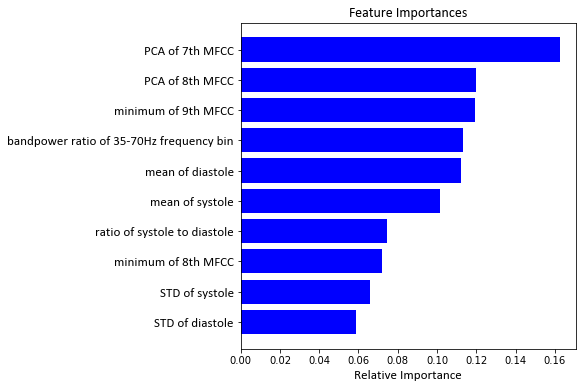

In [10]:
csfont = {'fontname':'Calibri'}
yticks = ["STD of diastole", "STD of systole", "minimum of 8th MFCC", "ratio of systole to diastole", "mean of systole", "mean of diastole", "bandpower ratio of 35-70Hz frequency bin", "minimum of 9th MFCC", "PCA of 8th MFCC", "PCA of 7th MFCC"]
features = all_features
importances = RF.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.title('Feature Importances',fontsize = 14, **csfont)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), yticks,fontsize = 13, **csfont)
plt.xlabel('Relative Importance',fontsize = 13, **csfont)
plt.show()